# Notebook 2 — Structural Degrees of Freedom at Fixed Size

This notebook evaluates **structural degrees of freedom (DoF) conditional on system size**
for residential photovoltaic installations and defines **configuration equivalence classes**
at fixed size.

It consumes the system-level structural configuration artifact produced upstream,
which enforces one row per `tts_link_id` and excludes sentinel identifiers prior to merge.
All configuration families represented here correspond to realized, valid system identities.

System size is treated as **fixed by analysis**, not as a configuration dimension.
Conditioning is performed using cohort-relative size indices and size bands to ensure
comparability across systems of similar scale.

The objectives of this notebook are threefold:

1. **Identify structural degrees of freedom at fixed size** by empirically determining
   which architectural and functional configuration dimensions vary independently when
   system size is held fixed.

2. **Derive structural constraints** by identifying dimensions that become effectively
   fixed or degenerate within size bands, yielding a structural constraint specification
   suitable for downstream analysis.

3. **Define configuration equivalence classes** by grouping systems that are structurally
   identical at fixed size, equating them on constrained dimensions while ignoring
   dimensions that vary freely.

Structural degrees of freedom are computed **at the variable level**, within size bands.
Each variable contributes degrees of freedom according to its admissible value structure
(binary, discrete, or ratio-based), evaluated only where that variable is structurally
defined and physically meaningful.

This notebook outputs the following artifacts:

- **Structural constraints** (`structural_constraints.parquet`), encoding which
  configuration dimensions are constrained or free at fixed size.
- **Configuration equivalence classes** (`configuration_classes.parquet`), assigning
  systems to structurally equivalent realizations at fixed size.

This notebook does not infer regimes, evaluate deviation surfaces, or assign risk.
Its role is strictly descriptive and structural, providing the dimensional and equivalence
substrate required for downstream scaling, regime geometry, and deviation analysis.



## Phase 1: Load Structural Configuration Artifact

This phase loads the unified structural configuration artifact produced in Notebook 1 and performs integrity checks required before analytic size conditioning.

At this stage:
- Structural configuration dimensions are fully assembled
- System size is present but **not yet conditioned**
- No grouping, binning, or restriction is applied

The purpose of this phase is to ensure the structural configuration dataset is valid, complete, and suitable for fixed-size conditioning in subsequent phases.


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np 
import os 

# Path to unified structural configuration artifact (Notebook 1 output)
INPUT_STRUCTURAL_CONFIG = Path(
    "../outputs/structural_configuration_pre_dof.parquet"
)

# Load artifact
df_structural = pd.read_parquet(INPUT_STRUCTURAL_CONFIG)

# Core integrity checks
assert "tts_link_id" in df_structural.columns
assert df_structural["tts_link_id"].is_unique

# Confirm size variable is present (but not conditioned)
assert "system_size_kw" in df_structural.columns

print("Rows:", len(df_structural))
print("Unique systems:", df_structural["tts_link_id"].nunique())
print("Columns:", df_structural.shape[1])


Rows: 103309
Unique systems: 103309
Columns: 48


## Phase 2: Fixed-Size Conditioning

This phase defines what it means to **hold system size fixed** for the purposes of
structural degrees-of-freedom analysis in Repo 3.

System size is conditioned **relative to its installation-year cohort** in order
to account for historical scale shifts and changing market baselines. Conditioning
is purely descriptive and establishes **comparability**, not evaluation.

No judgments regarding abnormality, deviation, efficiency, or risk are made in this
phase. Size conditioning serves only to place systems of different absolute sizes
onto a common, dimensionless scale suitable for downstream structural analysis.

All subsequent phases operate on **size-conditioned representations** rather than
raw system size.


In [4]:
#  Size conditioning variable

# Defensive checks: required columns must exist in the structural table
required_cols = [
    "system_size_kw",
    "baseline_expected_system_size_kw",
    "installation_year_cohort",
]

missing = [c for c in required_cols if c not in df_structural.columns]
assert not missing, f"Missing required columns for size conditioning: {missing}"


# Cohort-relative size index (dimensionless)

df_structural["size_index"] = (
    df_structural["system_size_kw"]
    / df_structural["baseline_expected_system_size_kw"]
)

# Sanity checks
assert df_structural["size_index"].notna().all(), (
    "size_index contains NaN values."
)

assert (df_structural["size_index"] > 0).all(), (
    "size_index must be strictly positive."
)

# Quick distribution check (no interpretation)
df_structural["size_index"].describe()


count    103309.000000
mean          1.342510
std           5.587414
min           0.000560
25%           0.759184
50%           1.000000
75%           1.354959
max         562.744925
Name: size_index, dtype: float64

In [6]:
#  Size band construction (descriptive)

# Number of bands (fixed for now)
N_BANDS = 10

df_structural["size_band"] = pd.qcut(
    df_structural["size_index"],
    q=N_BANDS,
    labels=False,
    duplicates="drop"
)

# Sanity checks
assert df_structural["size_band"].notna().all(), (
    "size_band contains NaN values."
)

df_structural["size_band"].value_counts().sort_index()



size_band
0    10344
1    10324
2    10326
3    10354
4    10685
5    10112
6    10193
7    10309
8    10334
9    10328
Name: count, dtype: int64

## Phase 3: Structural Degrees of Freedom at Fixed Size

Structural degrees of freedom (DoF) quantify the number of independent architectural
dimensions along which systems may vary once system size is held fixed.

In this notebook, structural DoF are defined exclusively over **functional and
architectural dimensions**—that is, variables that encode physical scaling
relationships, conversion topology, component geometry, or installation structure.
These dimensions reflect admissible system configurations rather than catalog-level
or identity-based variation.

Structural DoF are evaluated **within size bands**, where size bands represent
cohort-relative groupings of systems with comparable scale. Conditioning on size
bands ensures that observed variation reflects structural freedom rather than trivial
differences in absolute capacity.

For each size band, structural degrees of freedom are computed as the sum of
independent variation across admissible structural dimensions. Each dimension
contributes degrees of freedom according to its type:

- **Binary dimensions** contribute 1 DoF when both states are observed within a size
  band, and 0 otherwise.
- **Discrete count dimensions** contribute DoF equal to the number of distinct
  observed values minus one.
- **Ratio or binned continuous dimensions** contribute DoF equal to the number of
  occupied bins minus one.

This formulation captures the dimensionality of the structural configuration space
available to systems of comparable size. It does not evaluate performance, deviation,
or abnormality, and it does not assume the existence of regimes. Structural DoF
measurement is purely descriptive and serves as a prerequisite for downstream
analysis of scaling behavior and regime geometry.



### Admissible Structural Dimensions and DoF Accounting Rules

Structural degrees of freedom are computed over functional and architectural
dimensions that encode how systems may be physically realized once size is held
fixed.

The admissible structural dimensions used in this notebook fall into three classes:

### 1. Binary Architectural Dimensions
Binary indicators that distinguish mutually exclusive system architectures.
A binary dimension contributes 1 degree of freedom within a size band if both
states are observed, and 0 otherwise.

Examples:
- micro-inverter vs centralized conversion
- tracking vs fixed mounting
- ground-mounted vs roof-mounted

### 2. Discrete Geometric Dimensions
Integer-valued variables that encode component geometry or system evolution.
These dimensions contribute degrees of freedom equal to the number of distinct
observed values minus one within a size band.

Examples:
- number of inverter units
- number of installation events
- number of reported system sizes

### 3. Ratio-Based Structural Dimensions
Continuous variables that represent functional scaling relationships.
These are discretized into bins to reflect admissible structural regimes rather
than raw numeric variation. Degrees of freedom are computed as the number of
occupied bins minus one within a size band.

Examples:
- DC/AC ratio
- effective DC capacity relative to system size

Structural degrees of freedom are evaluated independently within each size band.
The resulting DoF quantify the dimensionality of the configuration space available
to systems of comparable size. No inference, deviation assessment, or regime
assignment is performed at this stage.


### Preliminary EDA: Structural Variable Coverage and Applicability

Before computing structural degrees of freedom, we perform a basic exploratory
assessment of candidate structural variables. This step verifies data coverage,
value domains, and architectural applicability, and ensures that derived variables
are well-defined before inclusion in structural analysis.

This EDA is descriptive only. No filtering, imputation, or structural assumptions
are applied at this stage.


In [22]:
# Global coverage and missingness

structural_candidates = [
    "module_total_dc_capacity",
    "inverter_total_ac_capacity",
    "has_micro_inverter",
    "has_dc_optimizer",
    "inverter_mixture_count",
    "module_mixture_count",
    "n_installation_dates",
    "n_size_reports",
]

coverage = (
    df_structural[structural_candidates]
    .isna()
    .mean()
    .rename("pct_missing")
    .to_frame()
    .assign(
        pct_present=lambda x: 1 - x["pct_missing"]
    )
    .sort_values("pct_missing", ascending=False)
)

coverage


,pct_missing,pct_present
module_total_dc_capacity,0.002517,0.997483
module_mixture_count,0.002517,0.997483
inverter_total_ac_capacity,0.000000,1.000000
has_micro_inverter,0.000000,1.000000
has_dc_optimizer,0.000000,1.000000
inverter_mixture_count,0.000000,1.000000
n_installation_dates,0.000000,1.000000
n_size_reports,0.000000,1.000000


In [23]:
# Domain checks for numeric structural variables


numeric_checks = [
    "module_total_dc_capacity",
    "inverter_total_ac_capacity",
    "inverter_mixture_count",
    "module_mixture_count",
]

df_structural[numeric_checks].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])


,module_total_dc_capacity,inverter_total_ac_capacity,inverter_mixture_count,module_mixture_count
count,1.030490e+05,103309.000000,103309.000000,103049.000000
mean,1.547437e+04,6.126049,0.500295,2.476007
std,5.901686e+04,50.724300,0.607299,0.729073
min,1.150000e+02,0.000000,0.000000,1.000000
1%,2.600000e+03,0.000000,0.000000,1.000000
5%,4.720000e+03,0.000000,0.000000,1.000000
50%,1.169000e+04,0.000000,0.000000,3.000000
95%,2.553000e+04,16.000000,2.000000,3.000000
99%,4.165260e+04,30.000000,2.000000,5.000000
max,5.675640e+06,5000.000000,3.000000,9.000000


In [24]:
# Architectural applicability cross-check

applicability = (
    df_structural
    .assign(
        inverter_ac_missing=lambda d: d["inverter_total_ac_capacity"].isna(),
        inverter_ac_zero=lambda d: d["inverter_total_ac_capacity"] == 0
    )
    .groupby("has_micro_inverter")[[
        "inverter_ac_missing",
        "inverter_ac_zero"
    ]]
    .mean()
)

applicability


,inverter_ac_missing,inverter_ac_zero
has_micro_inverter,,
False,0.0,0.557018


In [25]:
# Missingness by size band

(
    df_structural
    .groupby("size_band")["inverter_total_ac_capacity"]
    .apply(lambda s: s.isna().mean())
    .rename("pct_missing_ac_capacity")
)


size_band
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: pct_missing_ac_capacity, dtype: float64

### EDA Findings and Structural Implications

Preliminary exploratory analysis confirms near-complete coverage for most candidate
structural variables across all size bands. Missingness is minimal and does not drive
observed variation for binary or discrete configuration dimensions.

However, exploratory analysis reveals that a substantial fraction of systems report
**inverter total AC capacity equal to zero**, despite having valid system size and
configuration identity.

This state does **not** represent a physically meaningful system configuration.
A photovoltaic system with non-zero system size cannot, by definition, have zero
inverter AC capacity. The presence of zero AC capacity therefore reflects a
**reporting or data construction artifact**, not a structural architectural choice.

Accordingly, zero AC capacity is treated as an **undefined ratio state**, not as a
valid configuration realization.

Structural degrees of freedom are therefore evaluated **variable-specifically**.
For ratio-based variables that depend on inverter AC capacity (e.g. DC–AC ratio),
degrees of freedom are computed **only over the subset of systems where the ratio
is structurally defined** (i.e. AC capacity strictly positive).

Systems with undefined ratio values are **not excluded from the analysis as a whole**.
They continue to contribute to all other structural dimensions for which their data
is valid. This preserves sample integrity while avoiding the introduction of
assumptions, imputations, or fabricated ratios.

This approach maintains epistemic discipline by ensuring that each structural dimension
is evaluated only where its definition is physically and logically coherent.



### Functional Structural Degrees of Freedom at Fixed Size

With size conditioning established and variable-specific admissibility clarified,
structural degrees of freedom are now evaluated across functional and architectural
dimensions within each size band.

Each size band represents a cohort of systems with comparable scale.
Within each band, degrees of freedom quantify the dimensionality of the
**admissible configuration space** available to systems of that size.

Binary dimensions contribute one degree of freedom when both states are observed.
Discrete count dimensions contribute degrees of freedom equal to the number of
distinct observed values minus one.
Ratio-based dimensions contribute degrees of freedom based on occupied bins,
evaluated only where structurally defined.

The resulting DoF profiles describe how architectural flexibility evolves with system
size, independent of performance, deviation, or abnormality.
These profiles provide the structural substrate required for subsequent analysis
of scaling behavior, regime geometry, and deviation surfaces.



In [29]:
# Define structural dimensions

binary_dims = [
    "has_micro_inverter",
    "has_dc_optimizer",
    "is_tracking_system",
    "is_ground_mounted",
    "is_roof_mounted",
    "is_new_construction",
    "is_third_party_owned",
    "is_self_installed",
]

discrete_dims = [
    "inverter_mixture_count",
    "module_mixture_count",
    "n_installation_dates",
    "n_size_reports",
]

ratio_dims = {
    "dc_ac_ratio": 8,
}

# Defensive check
required = binary_dims + discrete_dims + list(ratio_dims.keys()) + ["size_band"]
missing = [c for c in required if c not in df_structural.columns]
assert not missing, f"Missing required structural columns: {missing}"

# Bin ratio-based dimensions conditionally
for col, n_bins in ratio_dims.items():
    bin_col = f"{col}_bin"

    # IMPORTANT: initialize with object dtype to accept Interval values
    df_structural[bin_col] = pd.Series(index=df_structural.index, dtype="object")

    valid = (
        df_structural[col].notna()
        & np.isfinite(df_structural[col])
        & (df_structural[col] > 0)
    )

    if valid.sum() > n_bins:
        df_structural.loc[valid, bin_col] = pd.qcut(
            df_structural.loc[valid, col],
            q=n_bins,
            duplicates="drop"
        )

ratio_bin_cols = [f"{c}_bin" for c in ratio_dims]

# Compute structural DoF per size band
records = []

for band, df_band in df_structural.groupby("size_band"):
    dof_total = 0
    breakdown = {}

    for col in binary_dims:
        k = df_band[col].dropna().nunique()
        dof = 1 if k == 2 else 0
        breakdown[col] = dof
        dof_total += dof

    for col in discrete_dims:
        k = df_band[col].dropna().nunique()
        dof = max(k - 1, 0)
        breakdown[col] = dof
        dof_total += dof

    for col in ratio_bin_cols:
        k = df_band[col].dropna().nunique()
        dof = max(k - 1, 0)
        breakdown[col] = dof
        dof_total += dof

    records.append({
        "size_band": band,
        "n_systems": len(df_band),
        "total_structural_dof": dof_total,
        "dof_breakdown": breakdown,
    })

df_structural_dof = (
    pd.DataFrame(records)
    .sort_values("size_band")
    .reset_index(drop=True)
)

df_structural_dof


,size_band,n_systems,total_structural_dof,dof_breakdown
0,0,10344,26,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
1,1,10324,27,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
2,2,10326,28,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
3,3,10354,27,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
4,4,10685,26,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
5,5,10112,28,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
6,6,10193,26,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
7,7,10309,28,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
8,8,10334,24,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."
9,9,10328,29,"{'has_micro_inverter': 0, 'has_dc_optimizer': ..."


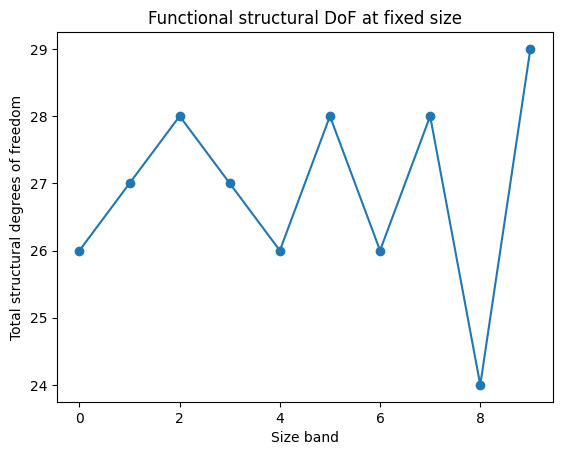

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    df_structural_dof["size_band"],
    df_structural_dof["total_structural_dof"],
    marker="o"
)
plt.xlabel("Size band")
plt.ylabel("Total structural degrees of freedom")
plt.title("Functional structural DoF at fixed size")
plt.show()
